### Marketing Campaign: Boost the profit of a marketing campaign

Here is an overview of the marketing features we will use to predict the Response Target. 

Data was downloaded from Kaggle: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign 

| Field                 | Description                                                   |
|-----------------------|---------------------------------------------------------------|
| AcceptedCmp1          | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| AcceptedCmp2          | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| AcceptedCmp3          | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| AcceptedCmp4          | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| AcceptedCmp5          | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| Response (target)     | 1 if customer accepted the offer in the last campaign, 0 otherwise |
| Complain              | 1 if customer complained in the last 2 years                     |
| DtCustomer            | Date of customer’s enrollment with the company                   |
| Education             | Customer’s level of education                                   |
| Marital               | Customer’s marital status                                       |
| Kidhome               | Number of small children in customer’s household                |
| Teenhome              | Number of teenagers in customer’s household                     |
| Income                | Customer’s yearly household income                              |
| MntFishProducts       | Amount spent on fish products in the last 2 years               |
| MntMeatProducts       | Amount spent on meat products in the last 2 years               |
| MntFruits             | Amount spent on fruits products in the last 2 years             |
| MntSweetProducts      | Amount spent on sweet products in the last 2 years              |
| MntWines              | Amount spent on wine products in the last 2 years               |
| MntGoldProds          | Amount spent on gold products in the last 2 years               |
| NumDealsPurchases     | Number of purchases made with a discount                        |
| NumCatalogPurchases   | Number of purchases made using a catalogue                      |
| NumStorePurchases     | Number of purchases made directly in stores                     |
| NumWebPurchases       | Number of purchases made through the company’s website          |
| NumWebVisitsMonth     | Number of visits to the company’s website in the last month     |
| Recency               | Number of days since the last purchase                          |


### Install libraries

In [2]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os

# notebook settings
sns.set_style("whitegrid")
sns.set_palette("bright")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


# sklearn for preprocessing and machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# models
import xgboost as xgb

# for saving the model
import pickle

# for weights and biases
import wandb
from wandb.xgboost import wandb_callback

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'learning': 'marketing-analytics', 
          'task': 'classification', 
          'env': 'local', 
          'datasource': 'kaggle', 
          'model':'xgboost'}

In [14]:
# For updating plots

my_colors = ["#EE4901", "#E77522", "#EFC459", "#C8E66E", "#8CC79C", "#4468B3", "#012599", "#3C2C66"]

### Load the data

In [3]:
PATH = 'data/marketing_campaign.csv'

df = pd.read_csv(PATH, sep=';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


#### Configure W&B and start a run

In [5]:
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='marketing-analytics', 
                     name=run_name,
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")

In [7]:
# Start a W&B run
run = wandb.init(project='marketing-analytics', name='basics_data', config=CONFIG)

In [8]:
# Save dataset artifact.
wandb.log({"df_hight":df.shape[0],
           "df_width":df.shape[1]})

In [10]:
wandb.finish()

In [11]:
# Log the dataset into W&B Artifactory
save_dataset_artifact(run_name='dataset_artifact', 
                      artifact_name='marketing_campaign', 
                      path=PATH)

Artifact has been saved successfully.


In [9]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the {PATH} dataset')

There are 2240 rows and 29 columns in the data/marketing_campaign.csv dataset


So far we've provided definitions for each of our features, along with downloading and loading the full marketing campaign dataset. We've also explored Weights & Biases (W&B), a powerful platform for running and monitoring different types of ML experiments. In our review of W&B, we've created two initial runs: the first run was to capture the shape of our dataset, and the second run was to store our first artificat by creating a function to store our marketing dataset.

We will now start exploring our dataset and prepare it for XGBoost.

### Data preprocessing

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

It looks like we have some missing data in at least one column. Let's verify. For fun, we'll do it with a visual chart.

<Figure size 1000x600 with 0 Axes>

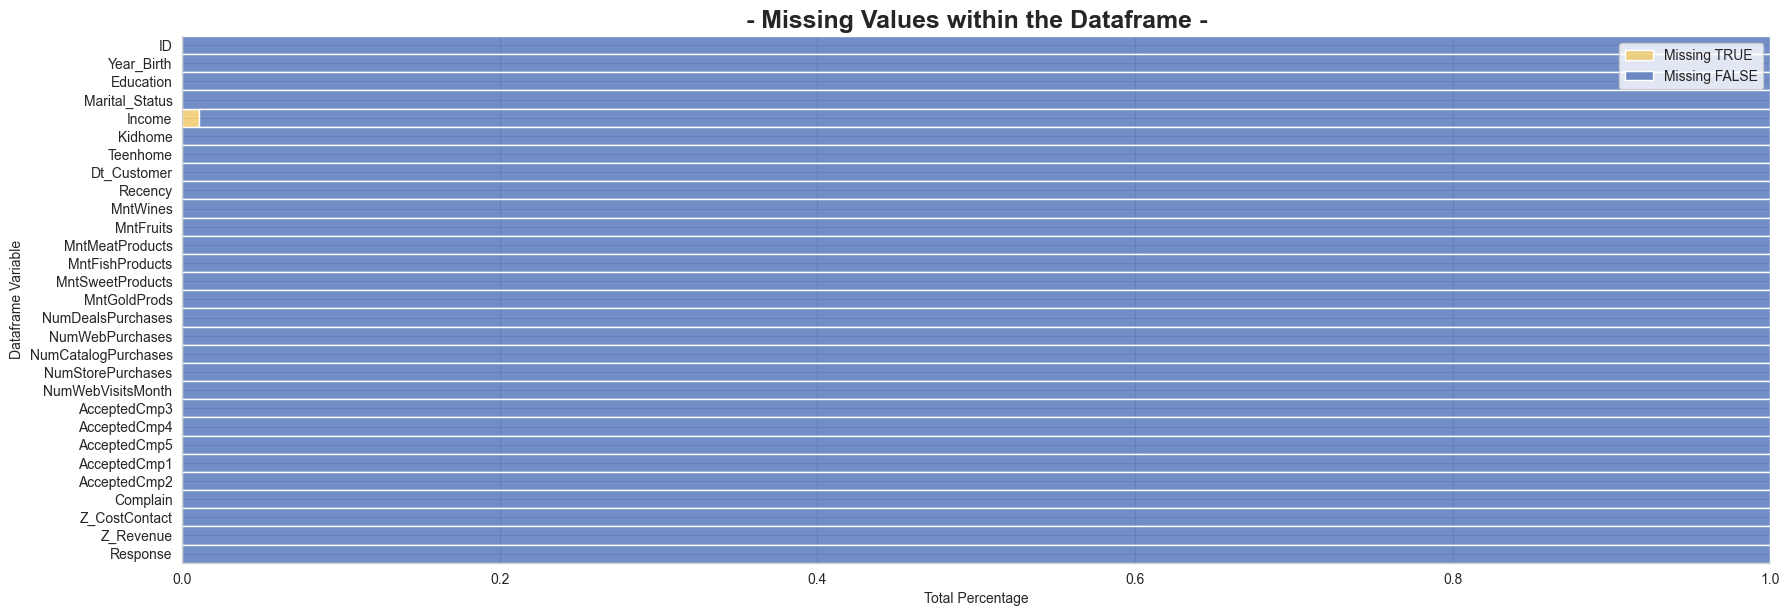

In [15]:
plt.figure(figsize=(10,6))

sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    
    # Change aspect of the chart
    aspect=3,
    height=6,
    # Change colors
    palette=[my_colors[5], my_colors[2]], 
    legend=False)

plt.title("- Missing Values within the Dataframe -", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.ylabel("Dataframe Variable")
plt.legend(["Missing TRUE", "Missing FALSE"]);

In [17]:
# Count missing values in each column
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [18]:
# Check for duplicates
df.duplicated().sum()

0

We have 24 missing values under Income. Not bad. We will determine how best to impute these values later on.

In [19]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


There is no defintion for the Z_ columns. The data does not appear to be helpful, as there are no variation in the values themselves. We will therefore drop the Z_ columns.

In [20]:
# Drop Z_CostContact and Z_Revenue 
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


We will change some of the column names to be more descriptive

In [21]:
# Update column names
df.rename(columns={'Recency': 'Days_Last_Purchase',
                   'MntWines': 'Wines',
                     'MntFruits': 'Fruits',
                     'MntMeatProducts': 'Meat',
                     'MntFishProducts': 'Fish',
                     'MntSweetProducts': 'Sweets',
                     'MntGoldProds': 'Gold',
                     'NumDealsPurchases': 'Discount_Purchases',
                     'NumWebPurchases': 'Web_Purchases',
                     'NumCatalogPurchases': 'Catalog_Purchases',
                     'NumStorePurchases': 'Store_Purchases',
                     'NumWebVisitsMonth': 'Web_Visits'}, inplace=True)

In [22]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Days_Last_Purchase,Wines,Fruits,Meat,Fish,Sweets,Gold,Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


Before we create new features, we will first transform our categorical variables into encoded numbers.

In [25]:
# Count the unique values in Education
df.Education.value_counts()

Education
2    1127
4     486
3     370
0     203
1      54
Name: count, dtype: int64

In [23]:
# Education
label_encoder = LabelEncoder()

label_encoder.fit(df['Education'])
df['Education'] = label_encoder.transform(df['Education'])

In [24]:
education_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
print(education_mappings)

{0: '2n Cycle', 1: 'Basic', 2: 'Graduation', 3: 'Master', 4: 'PhD'}


In [26]:
# Marital_Status
df.Marital_Status.value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [27]:
label_encoder.fit(df['Marital_Status'])
df['Marital_Status'] = label_encoder.transform(df['Marital_Status'])

In [28]:
relationship_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
print(relationship_mappings)

{0: 'Absurd', 1: 'Alone', 2: 'Divorced', 3: 'Married', 4: 'Single', 5: 'Together', 6: 'Widow', 7: 'YOLO'}


In [33]:
print(education_mappings)

{0: '2n Cycle', 1: 'Basic', 2: 'Graduation', 3: 'Master', 4: 'PhD'}


Let's log this info to W&B so we can refer to it more easily in the future.

In [35]:
run = wandb.init(project='marketing-analytics', name='categorical_encodings', config=CONFIG)
wandb.config.update({'education_mappings': education_mappings, 'relationship_mappings': relationship_mappings})
wandb.finish()

We will also convert the Dt_Customer column to a standard datetime dtype.

In [36]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [38]:
print(df['Dt_Customer'].dtype)

datetime64[ns]


We will now clean up the missing values in Income.

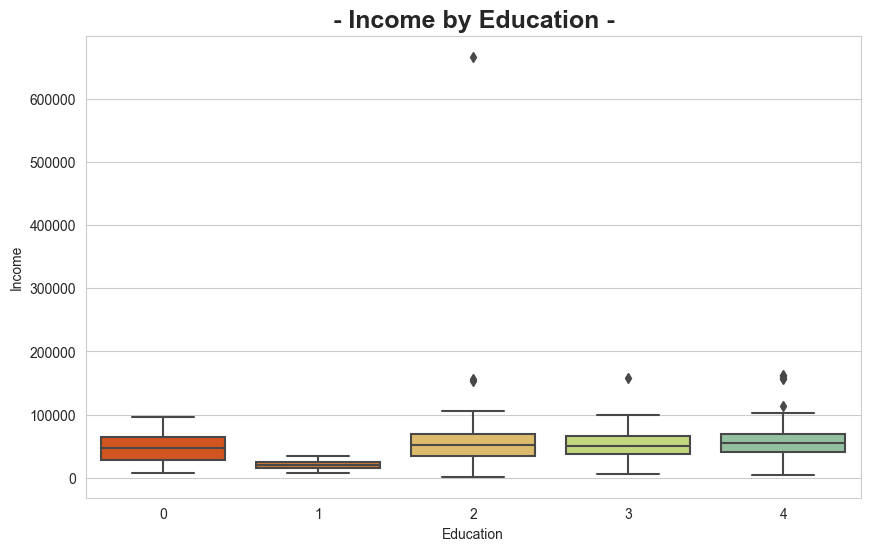

In [43]:
# How is the missing values in income distributed by education?
plt.figure(figsize=(10,6))
sns.boxplot(x='Education', y='Income', data=df, palette=my_colors)
plt.title("- Income by Education -", size=18, weight="bold")
plt.xlabel("Education")
plt.ylabel("Income");


It looks like we have at least one significant outlier for Education 2. We should remove this, as it will help to determine the best value for imputing missing data.

In [49]:
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]


In [50]:
original_rows = df.shape[0]
filtered_rows = df_filtered.shape[0]
rows_removed = original_rows - filtered_rows
print(f"Original number of rows: {original_rows}")
print(f"Number of rows after removing outliers: {filtered_rows}")
print(f"Number of rows removed: {rows_removed}")

Original number of rows: 2240
Number of rows after removing outliers: 2208
Number of rows removed: 32


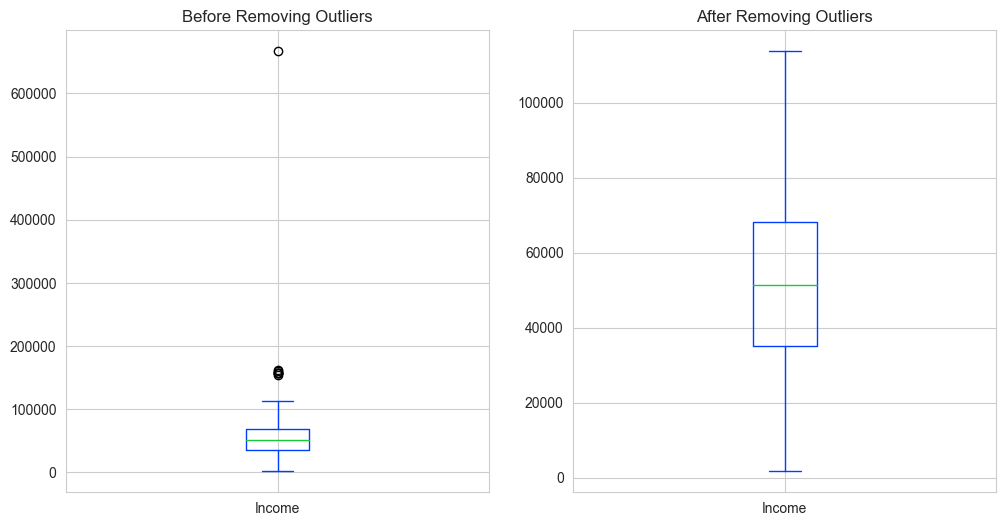

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['Income'].plot(kind='box', title='Before Removing Outliers')

plt.subplot(1, 2, 2)
df_filtered['Income'].plot(kind='box', title='After Removing Outliers')

plt.show()

In [55]:
df_filtered.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Days_Last_Purchase,Wines,Fruits,Meat,Fish,Sweets,Gold,Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,2,4,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,2,4,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,2,5,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,2,5,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,4,3,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [56]:
df_filtered.shape

(2208, 27)

In [62]:
# Calculate the median income for each education level in the filtered data
median_income_by_education = df_filtered.groupby('Education')['Income'].median()
print(median_income_by_education)

Education
0    46805.0
1    20744.0
2    51948.0
3    50920.5
4    55012.0
Name: Income, dtype: float64


In [63]:
# Show the number of missing values in Income by Education
df_filtered.groupby('Education')['Income'].apply(lambda x: x.isnull().sum())

Education
0    0
1    0
2    0
3    0
4    0
Name: Income, dtype: int64

It looks like we removed the null values when we removed the outliers. Let's leave this for now and come back to it if we think more formal imputation can help to improve our model in the future. 

### Feature Engineering

We will create some new features that may help us with model prediction. 

1. Total amount purchased (Add Wines, Fruits, Meat, Fish, Sweets, Gold).
2. Total items purchased (Add Web, Catalog, Store). We will not add Discount as it isn't clear where the discount occurred.
3. Total accepted campaigns (Add all Accepted Campaigns).

In [68]:
# Create a new column that adds wines, fruits, meat, fish, sweets, and gold
df_filtered['Total_Spent'] = df_filtered['Wines'] + df_filtered['Fruits'] + df_filtered['Meat'] + df_filtered['Fish'] + df_filtered['Sweets'] + df_filtered['Gold']

# Create a new column that adds the number of purchases
df_filtered['Total_Purchases'] = df_filtered['Discount_Purchases'] + df_filtered['Web_Purchases'] + df_filtered['Catalog_Purchases'] + df_filtered['Store_Purchases']

# Create a new column that adds the total number of accepted offers
df_filtered['Total_Accepted_Offers'] = df_filtered['AcceptedCmp3'] + df_filtered['AcceptedCmp4'] + df_filtered['AcceptedCmp5'] + df_filtered['AcceptedCmp1'] + df_filtered['AcceptedCmp2']

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Days_Last_Purchase,Wines,Fruits,Meat,Fish,Sweets,Gold,Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_Spent,Total_Purchases,Total_Accepted_Offers
0,5524,1957,2,4,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1617,25,0
1,2174,1954,2,4,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,27,6,0
2,4141,1965,2,5,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,776,21,0
3,6182,1984,2,5,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,53,8,0
4,5324,1981,4,3,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,422,19,0


### EDA and visualizations

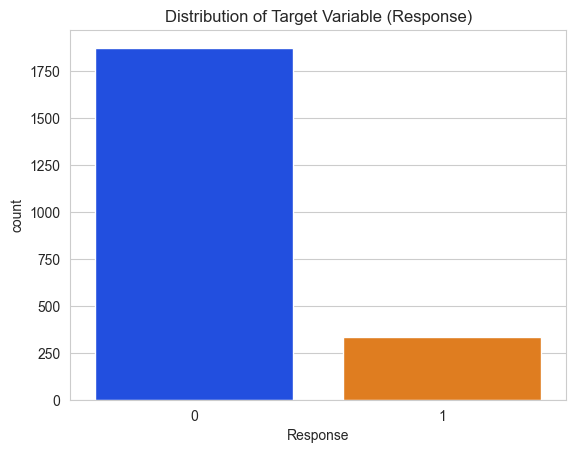

In [71]:
# Look at the distribution of the target variable
sns.countplot(x='Response', data=df_filtered)
plt.title('Distribution of Target Variable (Response)')
plt.show()

The dataset is heavily imbalanced. We run the risk of the model becoming biased toward the majority class, in this case negative responses. There are a couple of options that come to mind:

1. Use the XGBoost built-in parameter ``scale_pos_weight`` which helps in handling imbalanced datasets. The parameter is used to give more weight to the minority class and balance the target variable.
2. Use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class. This technique increases the number of instances of the minority class (in this case, Yes) by duplicating them or generating synthetic samples.

### Build a model

In [42]:
pass